#  Домашнее задание №4 — EchoBudget AI

##  Формулирование задачи в терминах ML

В рамках четвёртого этапа проекта рассматривается задача **кластеризации пользователей** финансового приложения **EchoBudget AI** на основе их поведенческих и демографических признаков. Цель — выявить естественные группы пользователей с похожим финансовым поведением для дальнейшей персонализации рекомендаций и пользовательского интерфейса.

---

## Цель задачи

Разработать и протестировать алгоритмы **кластеризации пользователей** по их доходам, расходам, целям накоплений и потенциальным зонам экономии. Это позволит:

- выявить сегменты пользователей (например, «тратят много, но хотят копить», «экономные с низким доходом» и т.п.);
- давать таргетированные рекомендации по оптимизации бюджета;


---

##  Тип ML-задачи

| № | Название задачи              | Тип ML-задачи       | Входные данные                      | Целевая переменная |
|---|------------------------------|---------------------|-------------------------------------|--------------------|
| 1 | Кластеризация пользователей | Unsupervised (без учителя) | Финансовые и демографические признаки | — |

---

##  Структура ноутбука

1.  Загрузка и первичная очистка данных  
2.  Анализ данных (EDA)  
3.  Предобработка (выбор признаков, масштабирование)  
4.  Кластеризация (KMeans и другие методы)  
5.  Интерпретация и визуализация кластеров  
6.  Обучение классификатора для определения кластера пользователя
7.  Обучение более сложного классификатора с optuna
8.  Выводы


##  Загрузка и первичная очистка данных

Для кластеризации пользователей мы используем открытый датасет с финансовыми данными из Индии (20,000 строк). Данные содержат информацию о доходах, расходах, сбережениях и потенциальных зонах экономии.



In [2]:
import pandas as pd

df = pd.read_csv("datasets/GOLDCLUSTERING.csv", sep=';')

print("Размер:", df.shape)
print("Колонки:", df.columns.tolist())
df.head()


Размер: (20000, 27)
Колонки: ['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education', 'Miscellaneous', 'Desired_Savings_Percentage', 'Desired_Savings', 'Disposable_Income', 'Potential_Savings_Groceries', 'Potential_Savings_Transport', 'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment', 'Potential_Savings_Utilities', 'Potential_Savings_Healthcare', 'Potential_Savings_Education', 'Potential_Savings_Miscellaneous']


,Income,Age,Dependents,Occupation,City_Tier,Rent,Loan_Repayment,Insurance,Groceries,Transport,...,Desired_Savings,Disposable_Income,Potential_Savings_Groceries,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous
0,44637.249636,49,0,Self_Employed,Tier_1,13391.174891,0.000000,2206.490129,6658.768341,2636.970696,...,6200.537192,11265.627707,1685.696222,328.895281,465.769172,195.151320,678.292859,67.682471,0.000000,85.735517
1,26858.596592,34,2,Retired,Tier_2,5371.719318,0.000000,869.522617,2818.444460,1543.018778,...,1923.176434,9676.818733,540.306561,119.347139,141.866089,234.131168,286.668408,6.603212,56.306874,97.388606
2,50367.605084,35,1,Student,Tier_3,7555.140763,4612.103386,2201.800050,6313.222081,3221.396403,...,7050.360422,13891.450624,1466.073984,473.549752,410.857129,459.965256,488.383423,7.290892,106.653597,138.542422
3,101455.600247,21,0,Self_Employed,Tier_3,15218.340037,6809.441427,4889.418087,14690.149363,7106.130005,...,16694.965136,31617.953615,1875.932770,762.020789,1241.017448,320.190594,1389.815033,193.502754,0.000000,296.041183
4,24875.283548,52,4,Professional,Tier_2,4975.056710,3112.609398,635.907170,3034.329665,1276.155163,...,1874.099434,6265.700532,788.953124,68.160766,61.712505,187.173750,194.117130,47.294591,67.388120,96.557076


##  Приведение типов и проверка пропусков

Перед тем как переходить к анализу данных, важно убедиться, что все признаки имеют корректные типы данных.

###  Нужно:

- Привести все числовые признаки к типу `float`
- Проверяем наличие пропущенных значений (после преобразования типов)



In [ ]:
non_numeric = ['Occupation', 'City_Tier']

df_clean = df.copy()

for col in df_clean.columns:
    if col not in non_numeric:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean.isnull().sum().sort_values(ascending=False).head(10)


Income                             0
Education                          0
Potential_Savings_Education        0
Potential_Savings_Healthcare       0
Potential_Savings_Utilities        0
Potential_Savings_Entertainment    0
Potential_Savings_Eating_Out       0
Potential_Savings_Transport        0
Potential_Savings_Groceries        0
Disposable_Income                  0
dtype: int64

##  📊 Исследовательский анализ данных (EDA)

После приведения типов проведём базовый EDA — исследуем распределения данных, наличие выбросов и категориальные признаки.

---

### Анализ категориальных переменных

Посмотрим на распределение значений в переменных `Occupation` и `City_Tier`. Это поможет понять, какие сегменты пользователей преобладают.


In [ ]:
df_clean['Occupation'].value_counts(normalize=True) * 100


Retired          25.095
Professional     25.055
Student          25.015
Self_Employed    24.835
Name: Occupation, dtype: float64

In [ ]:
df_clean['City_Tier'].value_counts(normalize=True) * 100

Tier_2    50.34
Tier_1    29.67
Tier_3    19.99
Name: City_Tier, dtype: float64

###  Распределения числовых признаков

Построим гистограммы ключевых признаков: дохода, возраста и располагаемого дохода.

Чтобы посмотреть 

- смещённость распределений 
- потенциальные выбросы
- структуру данных 


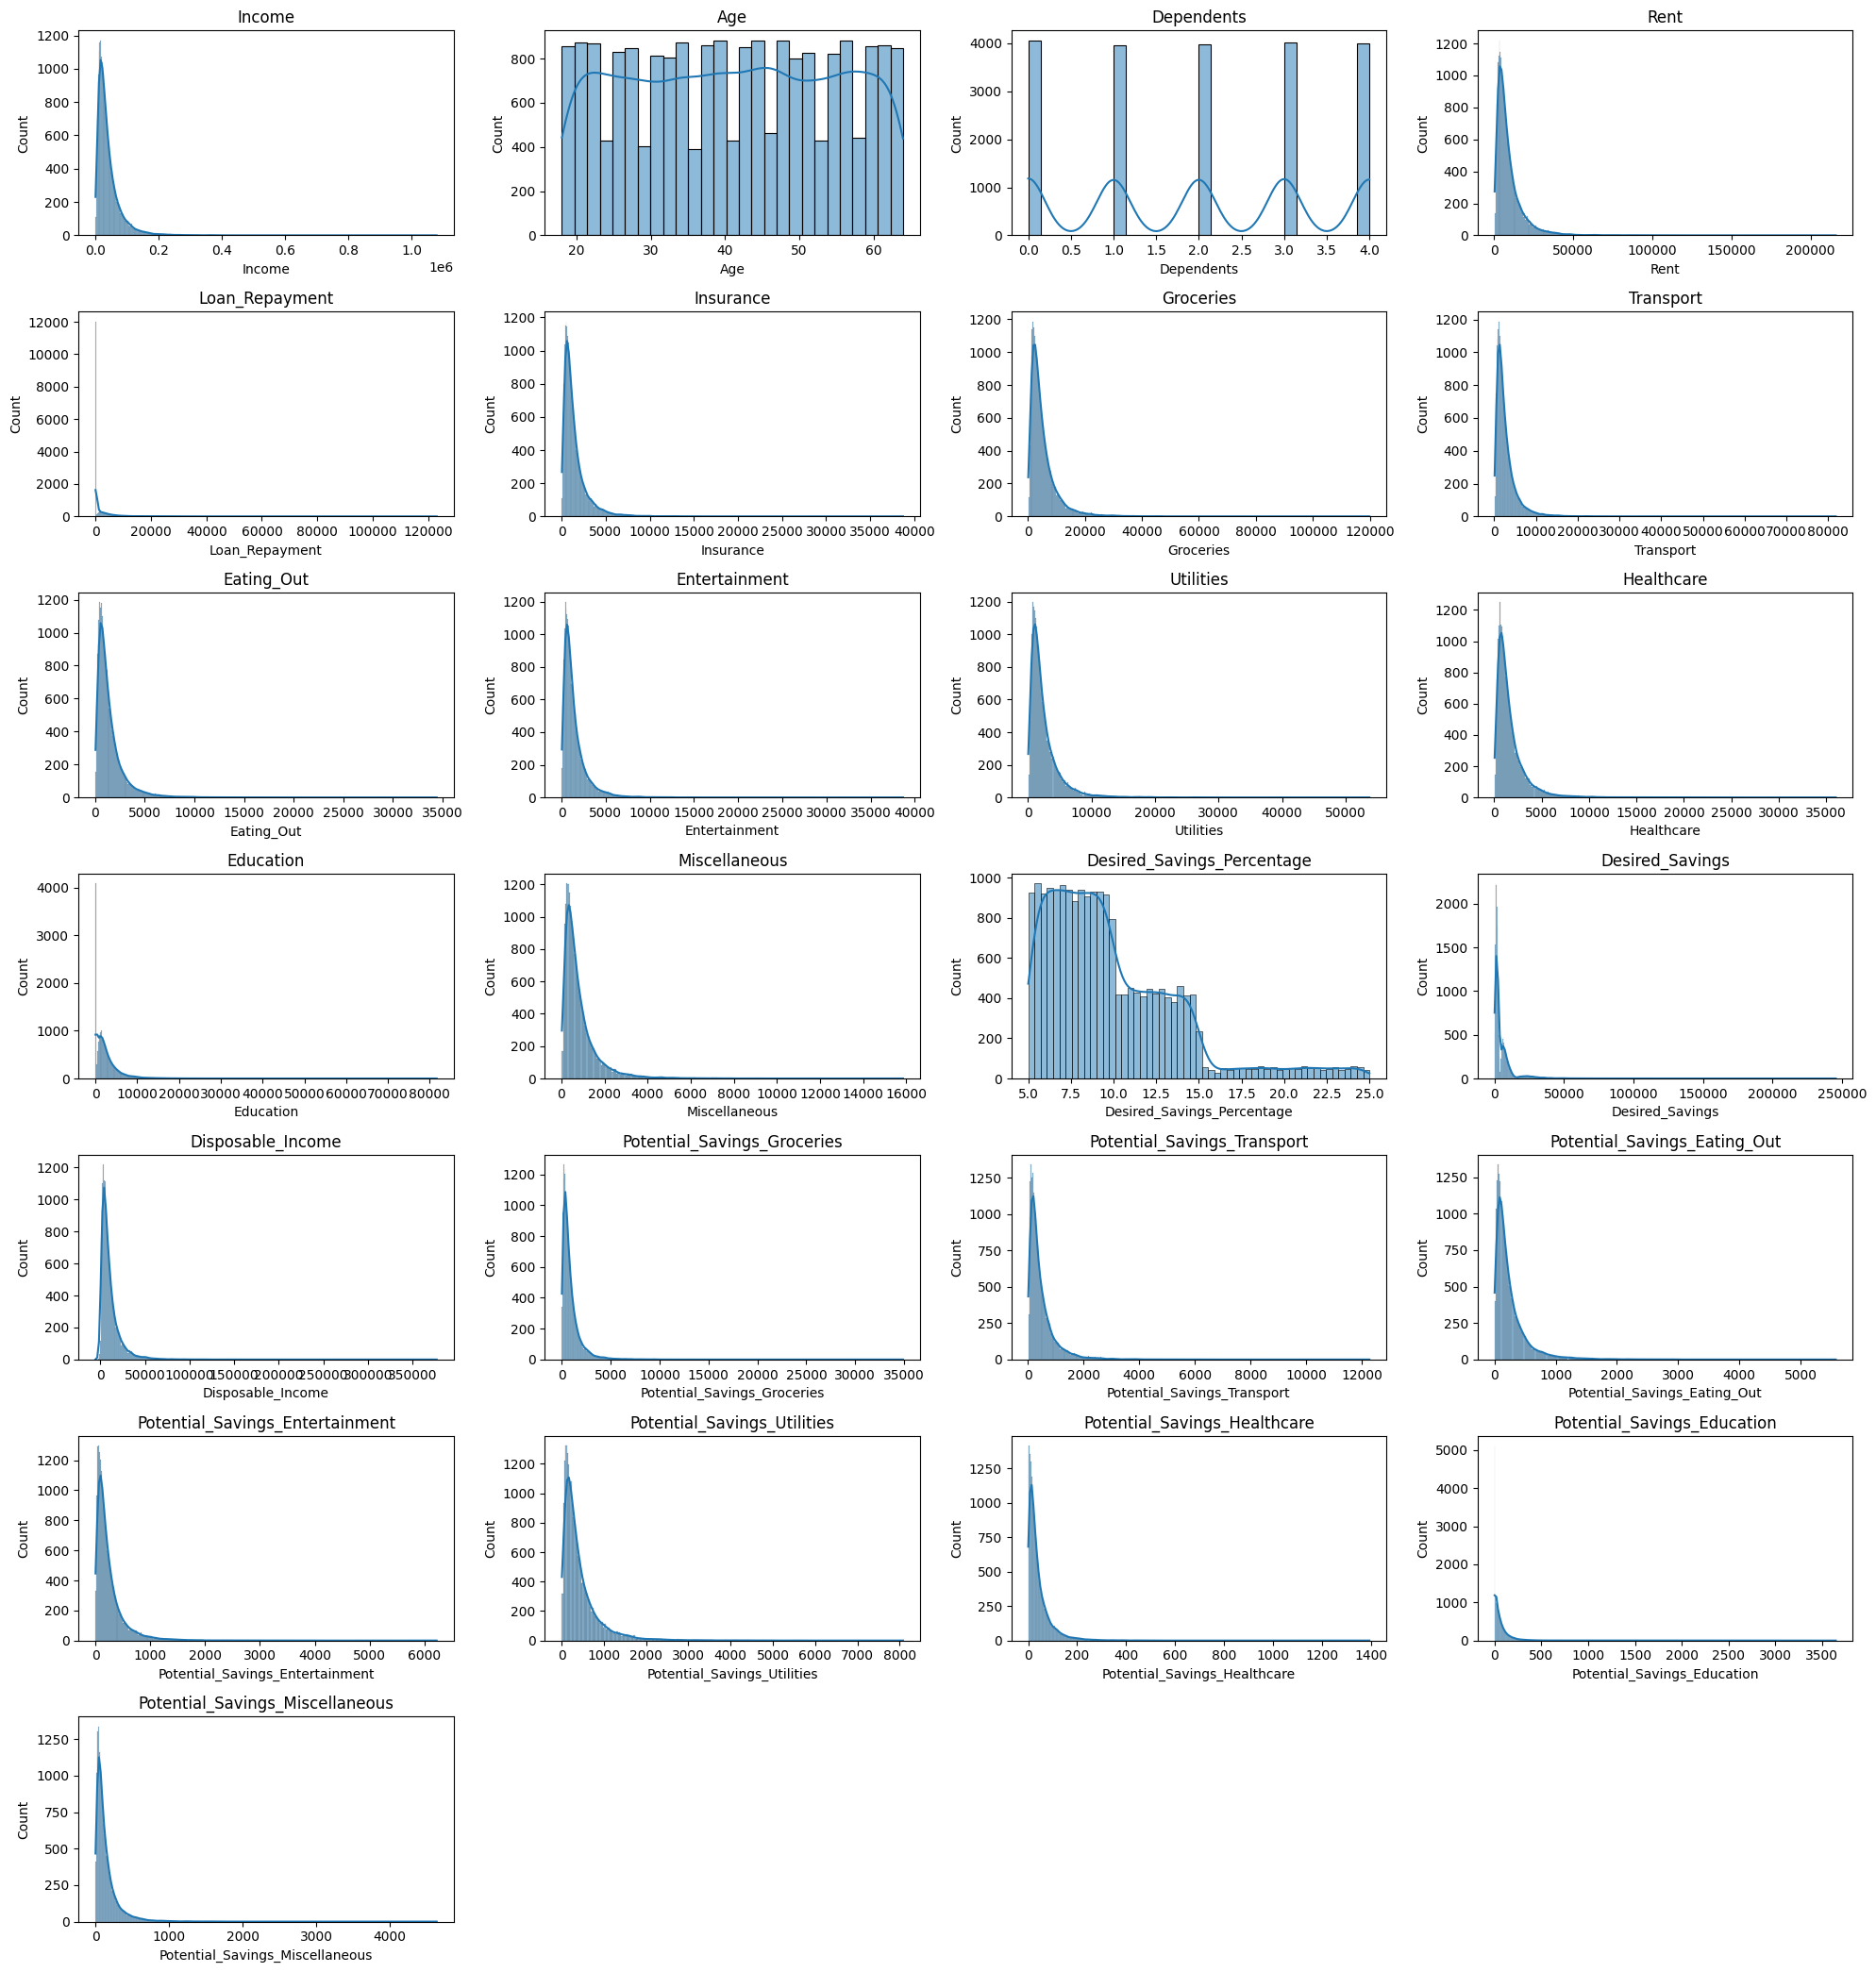

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

cols_per_row = 4
num_cols = len(numeric_cols)
num_rows = (num_cols // cols_per_row) + int(num_cols % cols_per_row > 0)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(cols_per_row * 5, num_rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df_clean[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


###  Корреляции признаков

Посмотрим, как связаны между собой числовые признаки. Это поможет выбрать фичи для кластеризации (например, исключить дублирующие).

Построим матрицу корреляций


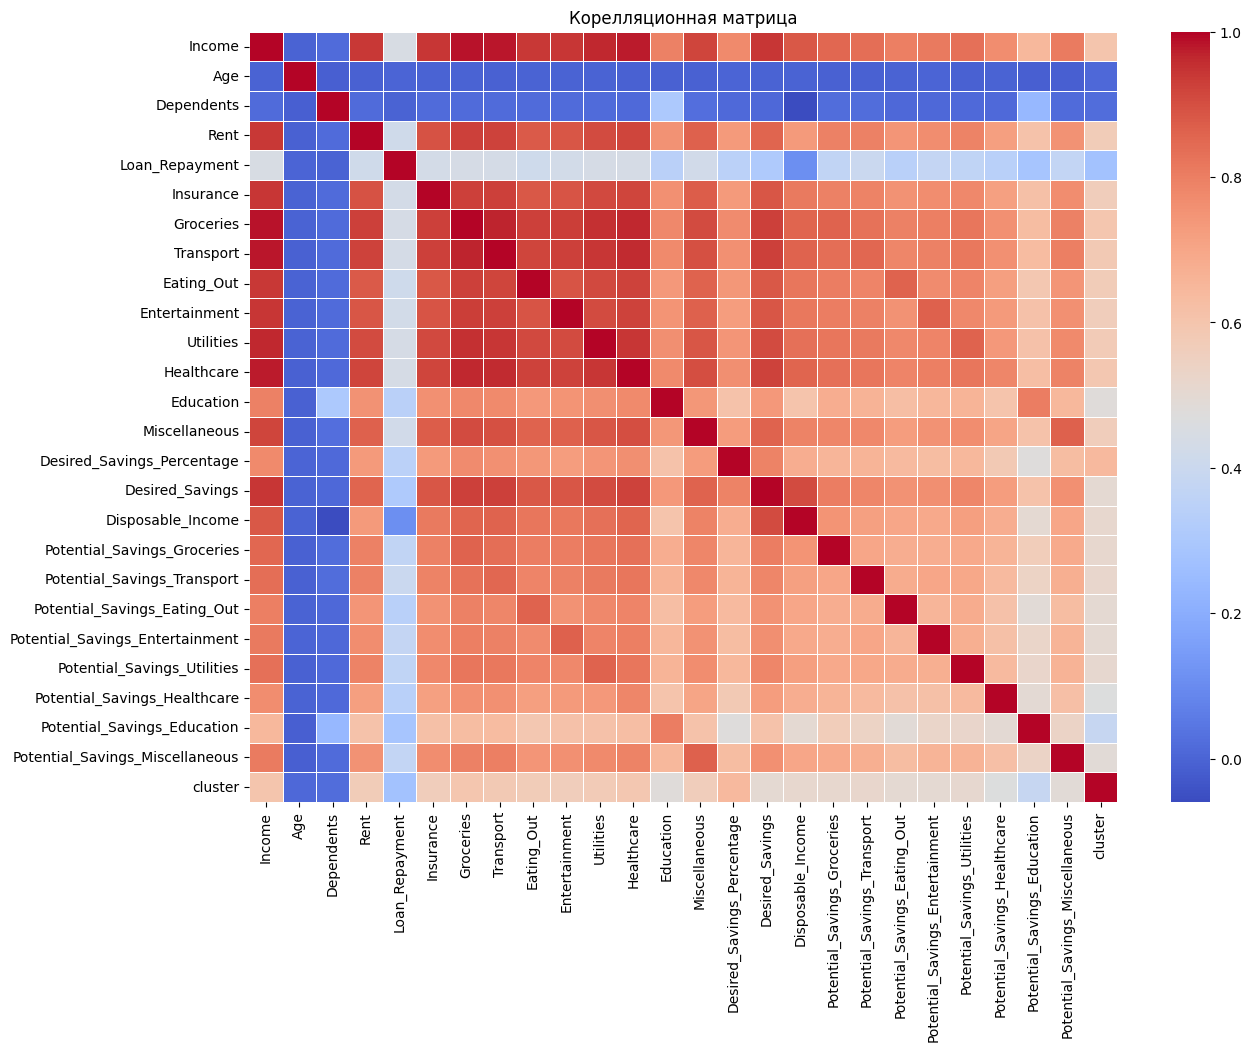

In [30]:
numeric_df = df_clean.drop(columns=non_numeric)

corr = numeric_df.corr()

# Визуализация
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Корелляционная матрица")
plt.show()


##  Предобработка перед кластеризацией

Перед тем как применять алгоритмы кластеризации , необходимо:

1.  Выбрать релевантные признаки для сегментации
2.  Масштабировать данные 
3. При необходимости — обработать выбросы или сделать PCA.

---

###  Выбор признаков

Для кластеризации мы будем использовать только числовые переменные, отражающие **доходы**, **расходы**, **цели сбережений** и **потенциальные сбережения**.

Исключим:
- `Age` и `Dependents` — они скорее демографические и плохо коррелируют
- `Desired_Savings_Percentage` — сильно коррелирует с другими
- `Occupation`, `City_Tier` — категориальные 


In [ ]:
selected_features = [
    'Income', 'Rent', 'Loan_Repayment', 'Insurance', 'Groceries', 'Transport',
    'Eating_Out', 'Entertainment', 'Utilities', 'Healthcare', 'Education',
    'Miscellaneous', 'Desired_Savings', 'Disposable_Income',
    'Potential_Savings_Groceries', 'Potential_Savings_Transport',
    'Potential_Savings_Eating_Out', 'Potential_Savings_Entertainment',
    'Potential_Savings_Utilities', 'Potential_Savings_Healthcare',
    'Potential_Savings_Education', 'Potential_Savings_Miscellaneous'
]

X = df_clean[selected_features].copy()


### Масштабирование признаков

Поскольку признаки выражены в разных единицах (от 100 до 100000+), применим `StandardScaler`.



In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


##  Визуализация данных и определение числа кластеров

Прежде чем обучать модель кластеризации, важно понять:

- как выглядят данные в проекции на 2D пространство;
- сколько кластеров может быть разумным числом 



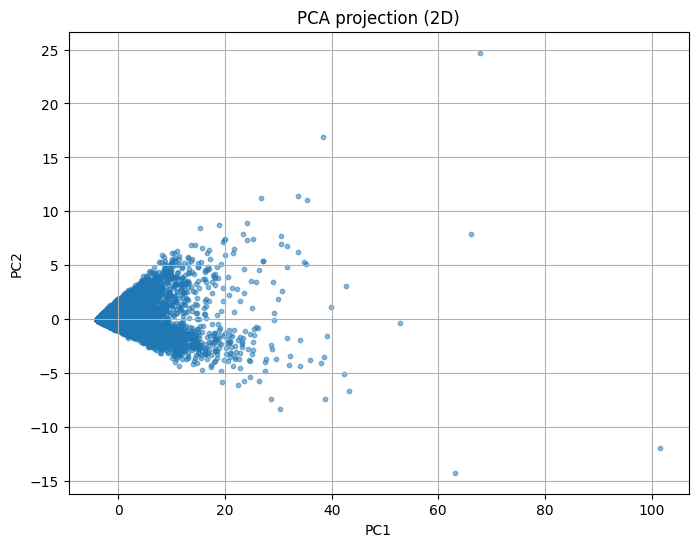

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=10)
plt.title("PCA проекция")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()






c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

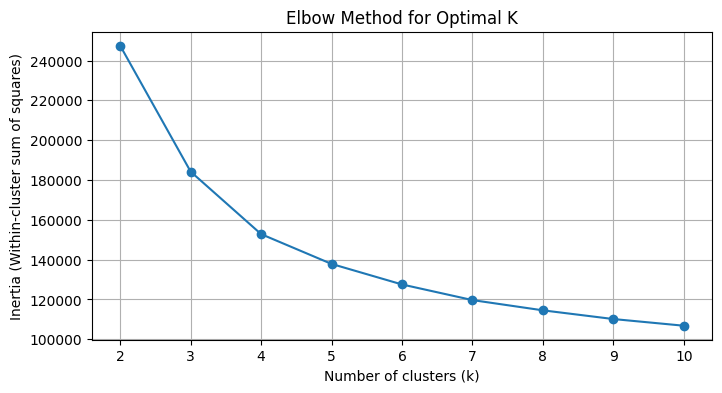

In [ ]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method для поиска K")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Инерция")
plt.grid(True)
plt.show()



c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

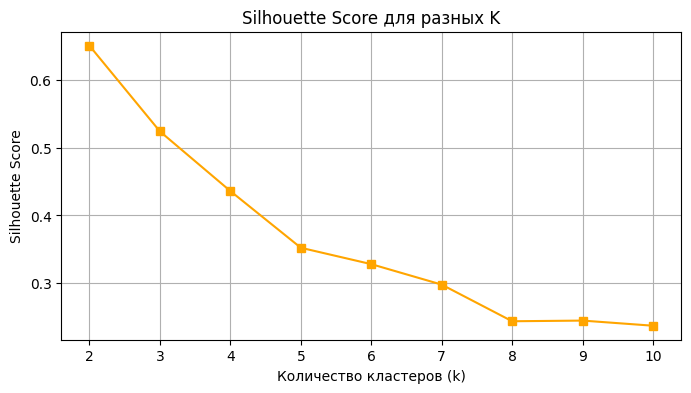

In [29]:

from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='s', color='orange')
plt.title("Silhouette Score для разных K")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

##  Кластеризация и анализ сегментов

Здесь:

1. Обучим модель `KMeans` с числом кластеров `k = 4`;
2. Добавим метки кластеров к пользователям;
3. Отобразим результат на PCA-графике;
4. Проанализируем поведение кластеров по ключевым метрикам.


In [ ]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

df_clean['cluster'] = cluster_labels


c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


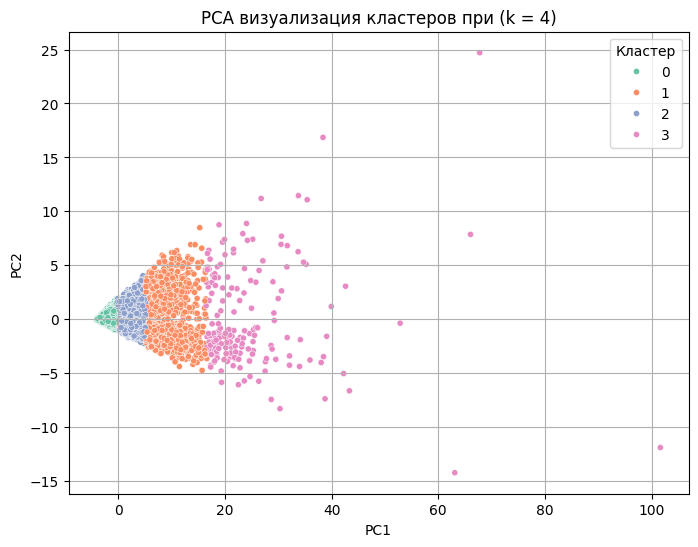

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='Set2', s=20)
plt.title("PCA визуализация кластеров при (k = 4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Кластер")
plt.grid(True)
plt.show()


Теперь посмотрим на **средние значения признаков внутри каждого кластера**, чтобы понять:

- кто тратит больше?
- кто копит?
- у кого выше доход?


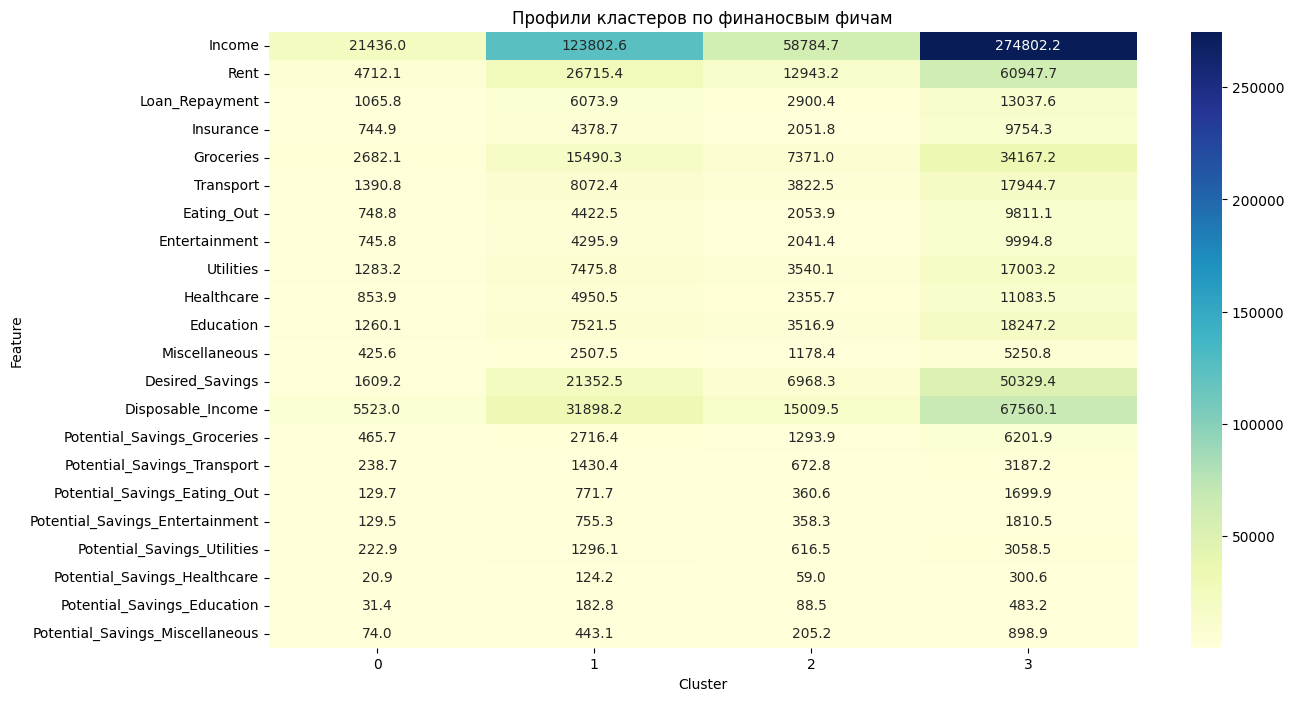

In [25]:
cluster_summary = df_clean.groupby("cluster")[selected_features].mean()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_summary.T, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title("Профили кластеров по финаносвым фичам")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()


## Автоматическая интерпретация кластеров

После кластеризации важно понять, **в чём особенности каждого сегмента**. Мы сравниваем средние значения признаков внутри каждого кластера с общим средним по всем пользователям и визуализируем это отклонение.

Чтобы:
- понять финансовое поведение сегмента;
- создать персональные рекомендации на основе будущего описания сегментов


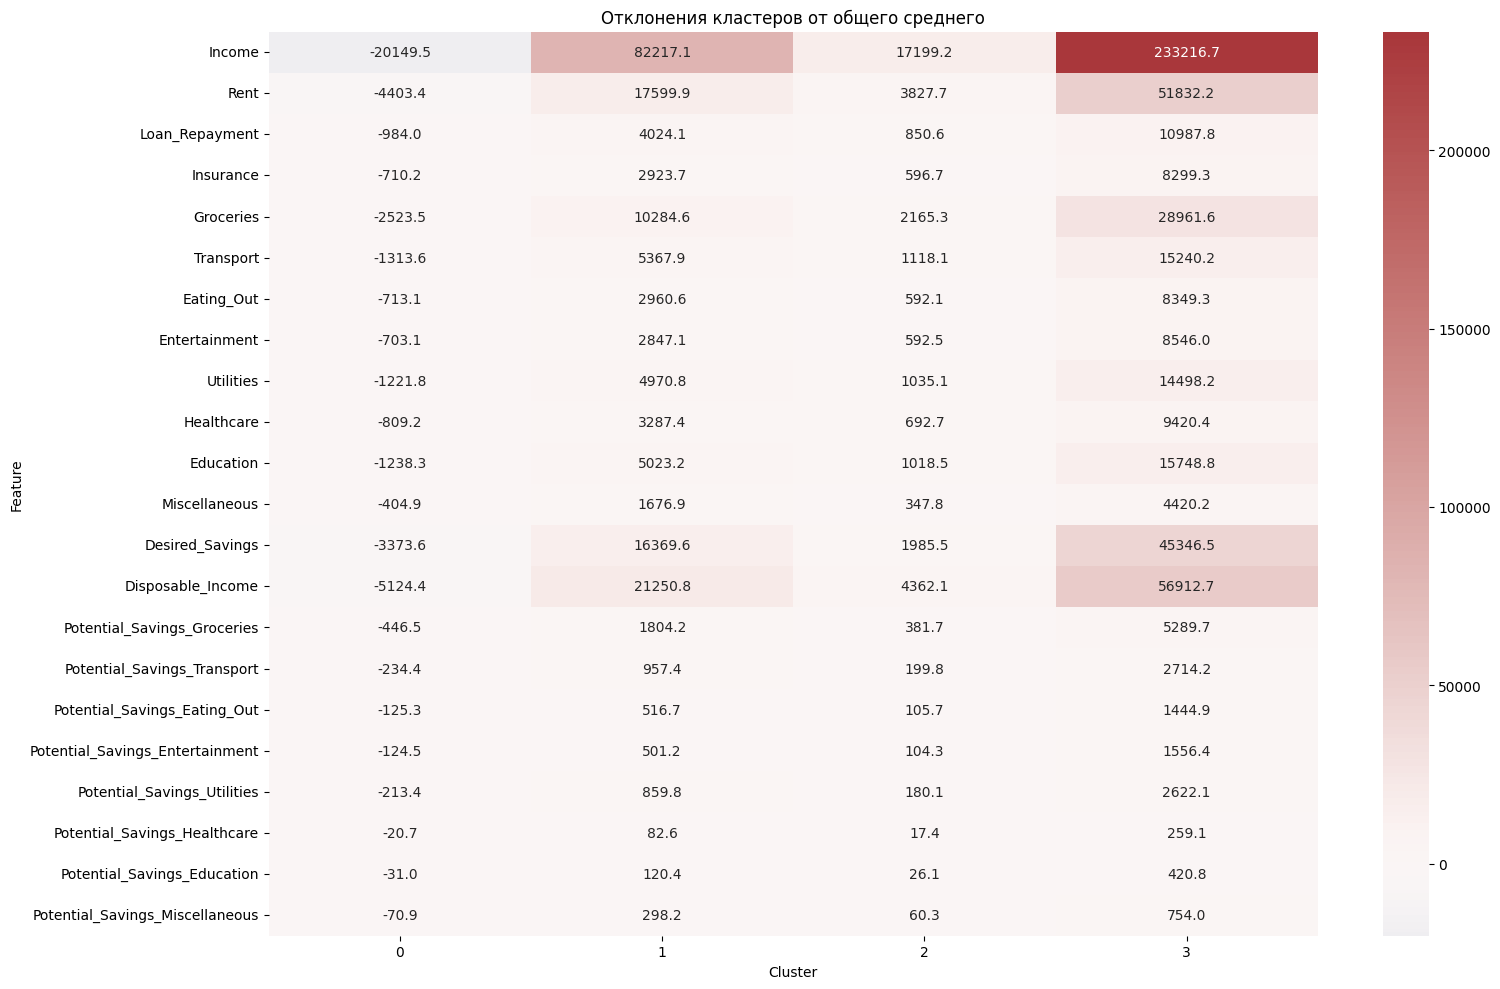

In [ ]:
cluster_means = df_clean.groupby("cluster")[selected_features].mean()

overall_means = df_clean[selected_features].mean()

deviation = cluster_means - overall_means

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
sns.heatmap(deviation.T, cmap="vlag", center=0, annot=True, fmt=".1f")
plt.title("Отклонения кластеров от общего среднего")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Дополнение: классификация типа пользователя (cluster → y)

После выполнения кластеризации, мы рассматриваем дополнительную задачу классификации:

**Цель:** обучить модель, которая по финансовым признакам пользователя определяет его поведенческий сегмент (кластер 0–3).

Эта задача:
- помогает понять, какие признаки лучше всего "объясняют" принадлежность к кластеру;
- может использоваться в проде для быстрой классификации новых пользователей.



In [ ]:
from sklearn.model_selection import train_test_split


X = df_clean[selected_features]
y = df_clean['cluster'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)



In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Результат LR:\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression:

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2562
           1       0.68      0.56      0.61       293
           2       0.73      0.79      0.76      1109
           3       0.10      0.08      0.09        36

    accuracy                           0.84      4000
   macro avg       0.61      0.58      0.59      4000
weighted avg       0.84      0.84      0.84      4000



c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Результат DT:\n")
print(classification_report(y_test, y_pred_dt))


Результат:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2562
           1       0.93      0.88      0.90       293
           2       0.93      0.94      0.93      1109
           3       0.93      0.75      0.83        36

    accuracy                           0.96      4000
   macro avg       0.94      0.89      0.91      4000
weighted avg       0.96      0.96      0.96      4000



In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1]
}

xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist' 
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    error_score='raise'  
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

model = grid_search.best_estimator_
y_pred_xgb = model.predict(X_test)

from sklearn.metrics import classification_report
print("XGBoost с подбором гиперпараметров:\n")
print(classification_report(y_test, y_pred_xgb))


Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
XGBoost с подбором гиперпараметров:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2562
           1       0.94      0.96      0.95       293
           2       0.97      0.97      0.97      1109
           3       0.93      0.78      0.85        36

    accuracy                           0.98      4000
   macro avg       0.96      0.92      0.94      4000
weighted avg       0.98      0.98      0.98      4000



In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "tree_method": "hist"
    }

    model = XGBClassifier(**params)
    score = cross_val_score(
        model, X_train, y_train, cv=3,
        scoring=make_scorer(f1_score, average="macro"),
        n_jobs=-1
    )
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Лучшая попытка:")
print(study.best_trial)

best_params = study.best_trial.params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred_optuna = best_model.predict(X_test)

from sklearn.metrics import classification_report
print("Отчет по оптимизации с Оптуна):\n")
print(classification_report(y_test, y_pred_optuna))


c:\Users\anatb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-27 22:48:24,405] A new study created in memory with name: no-name-175b860f-91ac-4bf7-9b6a-6d2eeeb8a697
[I 2025-06-27 22:48:26,898] Trial 0 finished with value: 0.9710240840712007 and parameters: {'n_estimators': 197, 'max_depth': 7, 'learning_rate': 0.13252164984407697, 'subsample': 0.5194994718229937, 'colsample_bytree': 0.8709992564695219}. Best is trial 0 with value: 0.9710240840712007.
[I 2025-06-27 22:48:28,585] Trial 1 finished with value: 0.9649408429669694 and parameters: {'n_estimators': 86, 'max_depth': 9, 'learning_rate': 0.17158510668214935, 'subsample': 0.8207714553610185, 'colsample_bytree': 0.921155029610293}. Best is trial 0 with value: 0.9710240840712007.
[I 2025-06-27 22:48:30,711] Tr

Best trial:
FrozenTrial(number=24, state=1, values=[0.9779823248190628], datetime_start=datetime.datetime(2025, 6, 27, 22, 49, 8, 651290), datetime_complete=datetime.datetime(2025, 6, 27, 22, 49, 10, 153339), params={'n_estimators': 166, 'max_depth': 3, 'learning_rate': 0.26609925751315405, 'subsample': 0.5065242638016753, 'colsample_bytree': 0.5913354593563813}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None)}, trial_id=24, value=None)
Classification Report (Optuna tuned XGBoost):

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2562
           1   

Accuracy: 0.9885
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2562
           1       0.96      0.98      0.97       293
           2       0.98      0.98      0.98      1109
           3       1.00      0.83      0.91        36

    accuracy                           0.99      4000
   macro avg       0.98      0.95      0.96      4000
weighted avg       0.99      0.99      0.99      4000



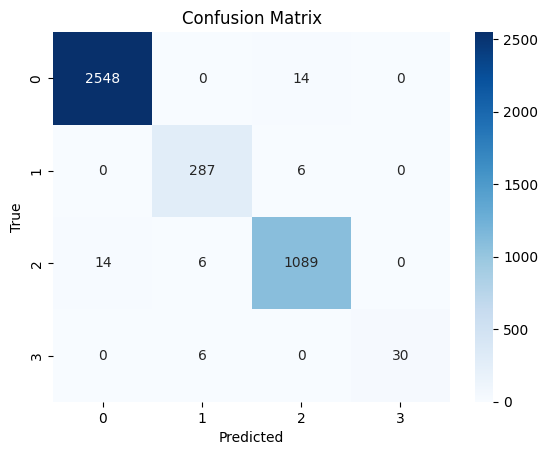

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


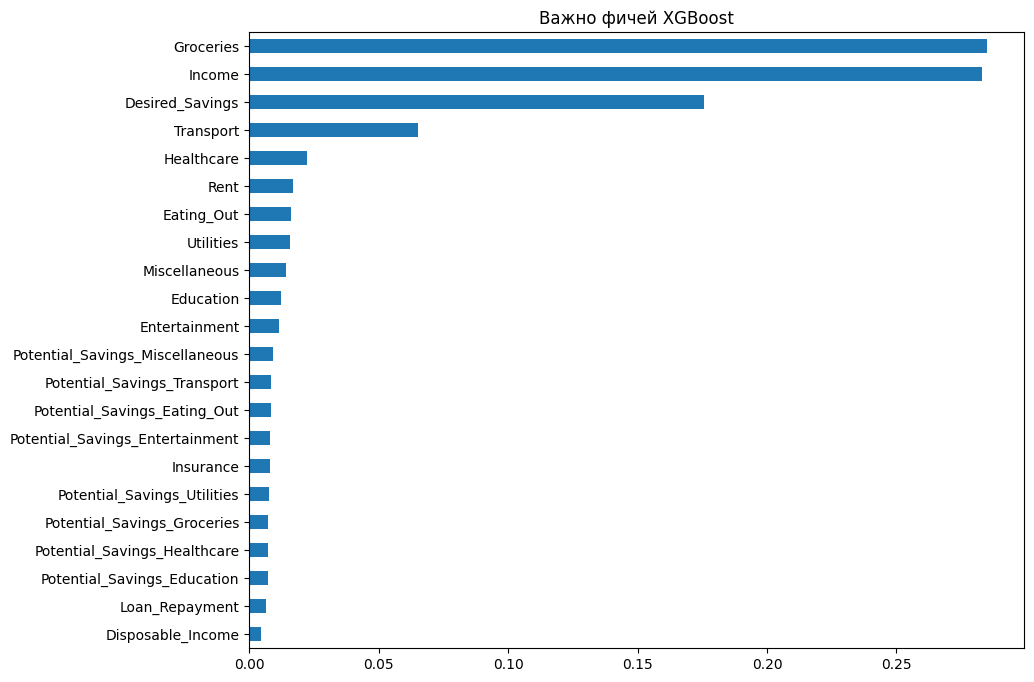

In [ ]:
import pandas as pd

feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))
plt.title("Важность фичей для XGBoost")
plt.show()


##  Оценка метрик качества и анализ результатов

Проведено сравнение трёх моделей: логистическая регрессия , дерево решений , и XGBoost с optuna). 

Используемые метрики:
- **Accuracy** — общая точность.
- **Macro F1-score** — усреднение без учета дисбаланса классов.
- **Weighted F1-score** — с учетом дисбаланса.

###  Результаты моделей:

####  XGBoost с GridSearchCV:
- **Accuracy**: 0.98  
- **Macro avg F1-score**: 0.94  
- **Weighted avg F1-score**: 0.98  
Модель хорошо справляется со всеми классами, включая редкий класс `3` (`F1=0.85`).

####  XGBoost с Optuna (усложнённая):
- **Accuracy**: 0.99  
- **Macro avg F1-score**: 0.97  
- **Weighted avg F1-score**: 0.99  
Улучшено качество предсказания редких классов, особенно `class 3` (`F1=0.93`).

####  Decision Tree:
- **Accuracy**: 0.96  
- **Macro avg F1-score**: 0.91  
- **Weighted avg F1-score**: 0.96  
Простая, но интерпретируемая модель. Чуть хуже справляется с редкими кластерами (`recall class 3 = 0.75`).

####  Logistic Regression:
- **Accuracy**: 0.84  
- **Macro avg F1-score**: 0.59  
- **Weighted avg F1-score**: 0.84  
Простая линейная модель. Плохо предсказывает малочисленные классы (`class 3 F1 = 0.09`).

---

###  Вывод:

- Простые модели дают отправную точку, но проигрывают по качеству.
- **XGBoost с подбором параметров показывает наилучшее качество**.
- **Optuna даёт дополнительный прирост** за счёт лучшего подбора гиперпараметров.
- **F1-macro** показал важность учёта всех классов при наличии дисбаланса.
